# Competitive Dynamics: Practicals

> This section contains practicals based on the [Competitive Dynamics chapter](competitive-dynamics.ipynb).

In [15]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from numpy.linalg import eigvals

```{note} Model convention used here

The practical writes the LV competition model as:

$$
\begin{aligned}
\frac{dN_1}{dt} &= r_1\,N_1\,(k_1 - N_1 - aN_2),\\
\frac{dN_2}{dt} &= r_2\,N_2\,(k_2 - bN_1 - N_2).
\end{aligned}
$$

The corresponding **isoclines** (nullclines) are:

$$
k_1 - N_1 - aN_2 = 0 \Rightarrow N_2=\frac{k_1-N_1}{a},\qquad
k_2 - bN_1 - N_2 = 0 \Rightarrow N_2=k_2-bN_1.
$$

This is equivalent to the more common scaled form
$\dot N_1=r_1N_1\bigl(1-(N_1+aN_2)/k_1\bigr)$ etc., up to a rescaling; the practical uses the **unscaled** form above.

```

## Utility: LV model, isoclines, equilibria, Jacobian

We will reuse these functions across problems (2‑1) and (2‑2).


In [16]:
def lv_rhs(t, y, r1, r2, k1, k2, a, b):

    n1, n2 = y

    dn1 = r1*n1*(k1 - n1 - a*n2)

    dn2 = r2*n2*(k2 - b*n1 - n2)

    return [dn1, dn2]





def isoclines(n1_grid, k1, k2, a, b):

    n2_iso1 = (k1 - n1_grid)/a

    n2_iso2 = k2 - b*n1_grid

    return n2_iso1, n2_iso2





def equilibria(k1, k2, a, b):

    # Four candidate equilibria (some may be infeasible)

    E00 = (0.0, 0.0)

    E10 = (k1, 0.0)

    E01 = (0.0, k2)

    denom = 1 - a*b

    if abs(denom) < 1e-12:

        Eco = (np.nan, np.nan)

    else:

        n1_star = (k1 - a*k2)/denom

        n2_star = (k2 - b*k1)/denom

        Eco = (n1_star, n2_star)

    return [E00, E10, E01, Eco]





def jacobian(n1, n2, r1, r2, k1, k2, a, b):

    # f1 = r1*n1*(k1 - n1 - a*n2)

    # f2 = r2*n2*(k2 - b*n1 - n2)

    df1_dn1 = r1*(k1 - n1 - a*n2) + r1*n1*(-1)

    df1_dn2 = r1*n1*(-a)

    df2_dn1 = r2*n2*(-b)

    df2_dn2 = r2*(k2 - b*n1 - n2) + r2*n2*(-1)

    return np.array([[df1_dn1, df1_dn2],

                     [df2_dn1, df2_dn2]])





def stability_at(eq, r1, r2, k1, k2, a, b):

    J = jacobian(eq[0], eq[1], r1, r2, k1, k2, a, b)

    ev = eigvals(J)

    stable = np.all(np.real(ev) < 0)

    feasible = (eq[0] >= -1e-9) and (eq[1] >= -1e-9)

    return ev, stable, feasible





def add_vector_field(ax, rhs, xlim, ylim, args=(), density=21, normalize=True, mask_fn=None, color='0.6', alpha=0.35):

    """Add a light vector field (quiver) to a 2D phase-plane axis.



    mask_fn(x, y) -> bool can be used to restrict arrows (e.g., simplex constraints).

    """

    xs = np.linspace(xlim[0], xlim[1], density)

    ys = np.linspace(ylim[0], ylim[1], density)

    X, Y = np.meshgrid(xs, ys)



    U = np.zeros_like(X, dtype=float)

    V = np.zeros_like(Y, dtype=float)

    for i in range(X.shape[0]):

        for j in range(X.shape[1]):

            x = float(X[i, j])

            y = float(Y[i, j])

            if mask_fn is not None and not mask_fn(x, y):

                U[i, j] = 0.0

                V[i, j] = 0.0

                continue

            u, v = rhs(0.0, [x, y], *args)

            U[i, j] = u

            V[i, j] = v



    if normalize:

        M = np.hypot(U, V)

        M[M == 0] = 1.0

        U = U / M

        V = V / M



    ax.quiver(

        X,

        Y,

        U,

        V,

        color=color,

        alpha=alpha,

        angles='xy',

        scale_units='xy',

        scale=25,

        width=0.0025,

        headwidth=3,

        headlength=4,

        pivot='mid',

        zorder=0,

    )


---

# (2‑1) Investigate the phase portrait of the Lotka–Volterra competition model

The 2‑species Lotka–Volterra competition model is given by

$$
\frac{dN_1}{dt} = r_1 (k_1 - N_1 - \alpha N_2) N_1,\qquad
\frac{dN_2}{dt} = r_2 (k_2 - \beta N_1 - N_2) N_2.
$$

```{note}
See also (theory notebook: [competitive-dynamics.ipynb](competitive-dynamics.ipynb)):
- Lotka–Volterra Competition: geometry in the phase plane → Model and isoclines
- Lotka–Volterra Competition: geometry in the phase plane → Four canonical outcomes
```

1) Implement the Lotka–Volterra competition model in Python to investigate its dynamical behaviour.

## Parameter set A (coexistence case)

2) Use parameters $k_1=10$, $k_2=7.5$, $\alpha=1$, $\beta=0.4$, $r_1=1$, $r_2=1$.

3) Use initial conditions $N_1(0)=1$, $N_2(0)=1$ and plot the solutions against time.
   Mark the initial conditions with a dot (or other marker).

4) Plot the solutions in the phase plane. As an indication choose your $N_1$ axis from $0$ to $20$ and the $N_2$ axis from $0$ to $12$.

5) The isoclines are given by the curves

$$
0 = k_1 - N_1 - \alpha N_2,\qquad
0 = k_2 - \beta N_1 - N_2.
$$

Plot the isoclines together with the solution.

6) Plot the **phase portrait**: plot solutions for a variety of different initial conditions simultaneously in the phase plane, and also plot the isoclines.

After you have done all this, save your work.

## Parameter set B (alternative stable states case)

Now repeat the exercise for the parameters $k_1=12$, $k_2=15$, $\alpha=1.2$, $\beta=1.8$, $r_1=1$, $r_2=1$.

As an indication choose your $N_1$ axis from $0$ to $12$ and the $N_2$ axis from $0$ to $15$. Don’t forget to plot the appropriate isoclines.

Compare the two phase portraits. How are they different?

Optional tool: https://phaseportrait.github.io/installation/


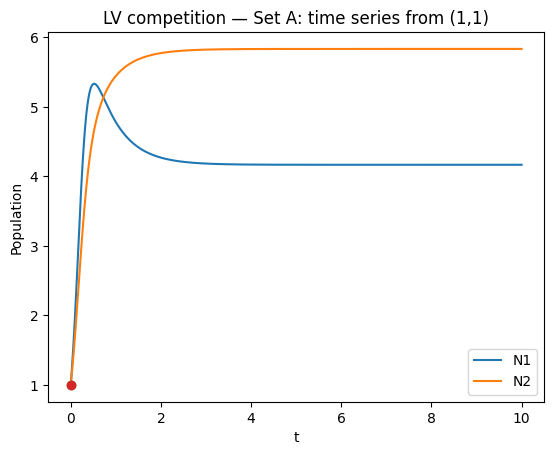

In [6]:
# Parameters: set A
r1 = r2 = 1.0
k1, k2 = 10.0, 7.5
a, b = 1.0, 0.4

# Integrate
y0 = [1.0, 1.0]
t_span = (0.0, 10.0)
t_eval = np.linspace(*t_span, 1200)

solA = solve_ivp(lv_rhs, t_span, y0, t_eval=t_eval, args=(r1, r2, k1, k2, a, b),
                 rtol=1e-9, atol=1e-12)

N1, N2 = solA.y

plt.figure()
plt.plot(solA.t, N1, label="N1")
plt.plot(solA.t, N2, label="N2")
plt.plot([0],[y0[0]], marker="o", linestyle="none")
plt.plot([0],[y0[1]], marker="o", linestyle="none")
plt.xlabel("t"); plt.ylabel("Population")
plt.title("LV competition — Set A: time series from (1,1)")
plt.legend()
plt.show()


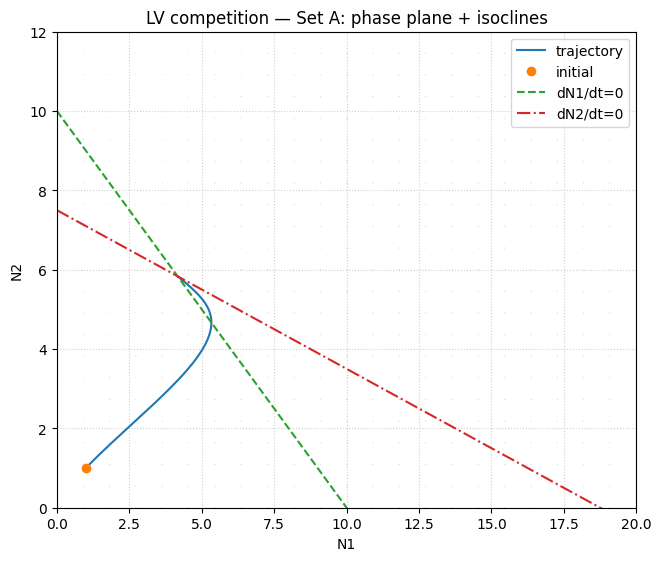

In [7]:
# Phase plane trajectory + isoclines

n1_grid = np.linspace(0, 20, 500)

iso1, iso2 = isoclines(n1_grid, k1, k2, a, b)



fig, ax = plt.subplots(figsize=(6.5, 5.5), constrained_layout=True)

add_vector_field(ax, lv_rhs, (0, 20), (0, 12), args=(r1, r2, k1, k2, a, b), density=23)



ax.plot(N1, N2, label="trajectory")

ax.plot([y0[0]], [y0[1]], marker="o", linestyle="none", label="initial")

ax.plot(n1_grid, iso1, "--", label="dN1/dt=0")

ax.plot(n1_grid, iso2, "-.", label="dN2/dt=0")

ax.set_xlim(0, 20)

ax.set_ylim(0, 12)

ax.set_xlabel("N1")

ax.set_ylabel("N2")

ax.set_title("LV competition — Set A: phase plane + isoclines")

ax.legend()

ax.grid(True, linestyle=':', alpha=0.6)

plt.show()


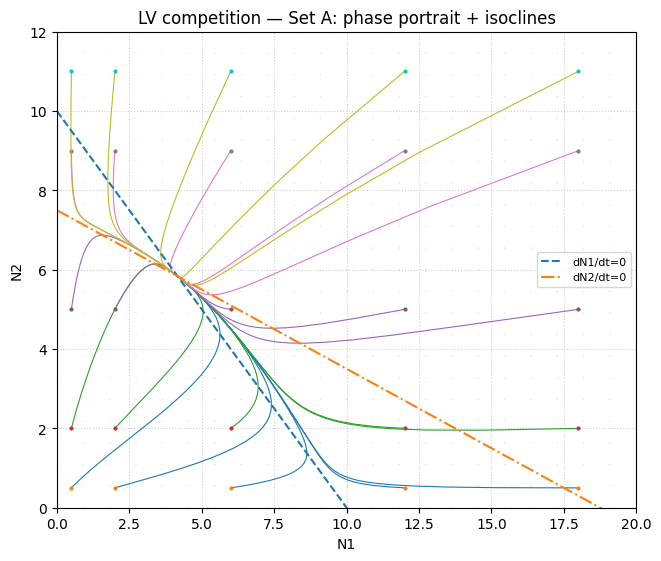

In [8]:
# Phase portrait: multiple initial conditions + isoclines

initial_conditions = []

for x in [0.5, 2, 6, 12, 18]:

    for y in [0.5, 2, 5, 9, 11]:

        initial_conditions.append([x, y])



fig, ax = plt.subplots(figsize=(6.5, 5.5), constrained_layout=True)

add_vector_field(ax, lv_rhs, (0, 20), (0, 12), args=(r1, r2, k1, k2, a, b), density=23)



for y0_ in initial_conditions:

    sol = solve_ivp(

        lv_rhs,

        (0, 10),

        y0_,

        t_eval=np.linspace(0, 10, 400),

        args=(r1, r2, k1, k2, a, b),

        rtol=1e-8,

        atol=1e-10,

    )

    ax.plot(sol.y[0], sol.y[1], linewidth=0.8)

    ax.plot([y0_[0]], [y0_[1]], marker="o", markersize=2, linestyle="none")



ax.plot(n1_grid, iso1, "--", linewidth=1.5, label="dN1/dt=0")

ax.plot(n1_grid, iso2, "-.", linewidth=1.5, label="dN2/dt=0")

ax.set_xlim(0, 20)

ax.set_ylim(0, 12)

ax.set_xlabel("N1")

ax.set_ylabel("N2")

ax.set_title("LV competition — Set A: phase portrait + isoclines")

ax.grid(True, linestyle=':', alpha=0.6)

ax.legend(fontsize=8)

plt.show()


### Equilibria & stability (Set A)

We list the four candidate equilibria and classify:
- **feasible** if $N_1^*,N_2^*\ge 0$
- **stable** if Jacobian eigenvalues have negative real parts

```{note}
See also (theory notebook: [competitive-dynamics.ipynb](competitive-dynamics.ipynb)):
- Equilibria and local stability → Equilibria
- Equilibria and local stability → Jacobian and eigenvalues
```


In [17]:
E_A = equilibria(k1, k2, a, b)
for lab, eq in zip(["E00","E10","E01","Eco"], E_A):
    ev, st, feas = stability_at(eq, r1, r2, k1, k2, a, b)
    print(f"{lab} = {eq} | feasible={feas} | stable={st} | eigenvalues={ev}")

E00 = (0.0, 0.0) | feasible=True | stable=False | eigenvalues=[10.   7.5]
E10 = (10.0, 0.0) | feasible=True | stable=False | eigenvalues=[-10.    3.5]
E01 = (0.0, 7.5) | feasible=True | stable=False | eigenvalues=[-7.5  2.5]
Eco = (4.166666666666667, 5.833333333333334) | feasible=True | stable=True | eigenvalues=[-1.77251388 -8.22748612]


## Parameter set B (alternative stable states case)

Repeat (2‑1) for:
- $k_1=12$, $k_2=15$
- $\alpha=1.2$, $\beta=1.8$
- $r_1=r_2=1$

With the practical’s suggested axes:
- $N_1\in[0,12]$, $N_2\in[0,15]$

```{note}
See also (theory notebook: [competitive-dynamics.ipynb](competitive-dynamics.ipynb)):
- Bifurcations, catastrophic shifts, and hysteresis → LV bistability as a threshold phenomenon
```


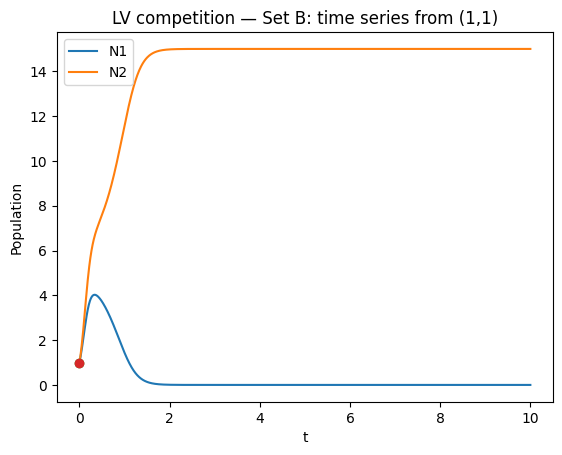

In [9]:
# Parameters: set B
r1 = r2 = 1.0
k1b, k2b = 12.0, 15.0
ab, bb = 1.2, 1.8

y0 = [1.0, 1.0]
t_span = (0.0, 10.0)
t_eval = np.linspace(*t_span, 1200)

solB = solve_ivp(lv_rhs, t_span, y0, t_eval=t_eval, args=(r1, r2, k1b, k2b, ab, bb),
                 rtol=1e-9, atol=1e-12)

N1b, N2b = solB.y

plt.figure()
plt.plot(solB.t, N1b, label="N1")
plt.plot(solB.t, N2b, label="N2")
plt.plot([0],[y0[0]], marker="o", linestyle="none")
plt.plot([0],[y0[1]], marker="o", linestyle="none")
plt.xlabel("t"); plt.ylabel("Population")
plt.title("LV competition — Set B: time series from (1,1)")
plt.legend()
plt.show()


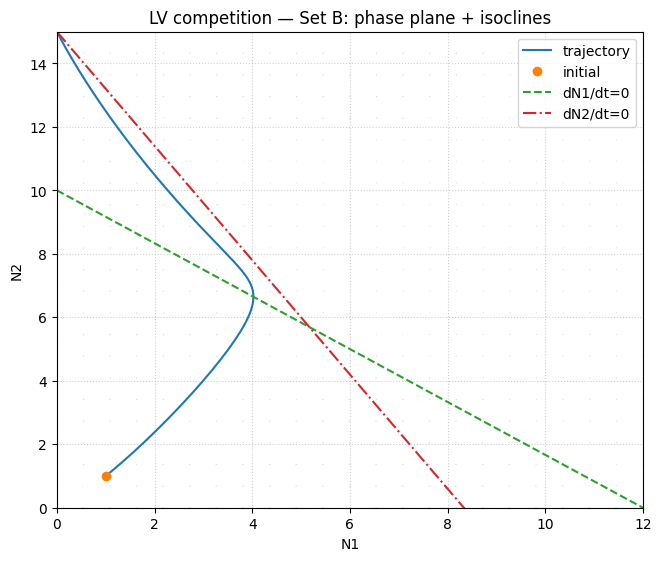

In [10]:
# Phase plane + isoclines (Set B)

n1_grid_b = np.linspace(0, 12, 500)

iso1b, iso2b = isoclines(n1_grid_b, k1b, k2b, ab, bb)



fig, ax = plt.subplots(figsize=(6.5, 5.5), constrained_layout=True)

add_vector_field(ax, lv_rhs, (0, 12), (0, 15), args=(r1, r2, k1b, k2b, ab, bb), density=23)



ax.plot(N1b, N2b, label="trajectory")

ax.plot([y0[0]], [y0[1]], marker="o", linestyle="none", label="initial")

ax.plot(n1_grid_b, iso1b, "--", label="dN1/dt=0")

ax.plot(n1_grid_b, iso2b, "-.", label="dN2/dt=0")

ax.set_xlim(0, 12)

ax.set_ylim(0, 15)

ax.set_xlabel("N1")

ax.set_ylabel("N2")

ax.set_title("LV competition — Set B: phase plane + isoclines")

ax.legend()

ax.grid(True, linestyle=':', alpha=0.6)

plt.show()


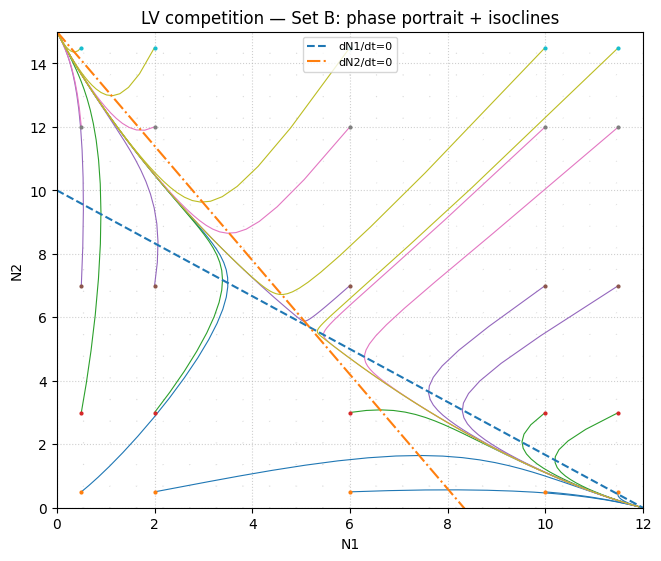

In [11]:
# Phase portrait (Set B)

initial_conditionsB = []

for x in [0.5, 2, 6, 10, 11.5]:

    for y in [0.5, 3, 7, 12, 14.5]:

        initial_conditionsB.append([x, y])



fig, ax = plt.subplots(figsize=(6.5, 5.5), constrained_layout=True)

add_vector_field(ax, lv_rhs, (0, 12), (0, 15), args=(r1, r2, k1b, k2b, ab, bb), density=23)



for y0_ in initial_conditionsB:

    sol = solve_ivp(

        lv_rhs,

        (0, 10),

        y0_,

        t_eval=np.linspace(0, 10, 400),

        args=(r1, r2, k1b, k2b, ab, bb),

        rtol=1e-8,

        atol=1e-10,

    )

    ax.plot(sol.y[0], sol.y[1], linewidth=0.8)

    ax.plot([y0_[0]], [y0_[1]], marker="o", markersize=2, linestyle="none")



ax.plot(n1_grid_b, iso1b, "--", linewidth=1.5, label="dN1/dt=0")

ax.plot(n1_grid_b, iso2b, "-.", linewidth=1.5, label="dN2/dt=0")

ax.set_xlim(0, 12)

ax.set_ylim(0, 15)

ax.set_xlabel("N1")

ax.set_ylabel("N2")

ax.set_title("LV competition — Set B: phase portrait + isoclines")

ax.grid(True, linestyle=':', alpha=0.6)

ax.legend(fontsize=8)

plt.show()


### Equilibria & stability (Set B)

In [18]:
E_B = equilibria(k1b, k2b, ab, bb)
for lab, eq in zip(["E00","E10","E01","Eco"], E_B):
    ev, st, feas = stability_at(eq, r1, r2, k1b, k2b, ab, bb)
    print(f"{lab} = {eq} | feasible={feas} | stable={st} | eigenvalues={ev}")

E00 = (0.0, 0.0) | feasible=True | stable=False | eigenvalues=[12. 15.]
E10 = (12.0, 0.0) | feasible=True | stable=True | eigenvalues=[-12.   -6.6]
E01 = (0.0, 15.0) | feasible=True | stable=True | eigenvalues=[-15.  -6.]
Eco = (5.1724137931034475, 5.689655172413794) | feasible=True | stable=False | eigenvalues=[  2.54606189 -13.40813086]


### Compare Set A vs Set B (qualitative)

- **Set A** typically yields a feasible, stable **coexistence** equilibrium $(N_1^*,N_2^*)$.
- **Set B** typically yields **bistability**: both single‑species equilibria $(k_1,0)$ and $(0,k_2)$ can be stable, separated by an interior saddle.


---

# (2‑2) Make a 1‑parameter bifurcation diagram of the Lotka–Volterra competition model

```{note}
**What are AUTO/XPP?**

- **XPP** (often “XPPAut”) is a small interactive program for simulating ODE models and exploring their dynamics.
- **AUTO** is a numerical continuation package (often used via XPP) that can *continue* equilibria/limit cycles as a parameter changes and automatically label branches as stable vs unstable.
```

In a 2D system, “finding unstable equilibria by simulation” is not straightforward. In AUTO/XPP you can continue equilibria and label stable/unstable branches; here we exploit that the LV equilibria are explicit and classify stability using the Jacobian.

```{note}
See also (theory notebook: [competitive-dynamics.ipynb](competitive-dynamics.ipynb)):
- Equilibria and local stability
- Bifurcations, catastrophic shifts, and hysteresis
```

Original practical instruction (XPP/AUTO route): use the files
- `content/lectures/ecolmod_vj/code/lvcomp1.ode`
- `content/lectures/ecolmod_vj/code/lvcomp2.ode`

to draw a bifurcation diagram to plot $N_2$ vs $k_1$. Plot the same diagram for $N_2$ vs $k_2$.

When you look at the bifurcation diagram, you see many equilibrium lines (some stable, some unstable). Not all of these correspond to biologically feasible equilibria.

To get some feeling for what the lines mean, plot them as functions of $N_1$ and as functions of $N_2$ (in AUTO: Axes → hi‑lo and change the Y‑axis). For some equilibria you will see that either $N_1=0$, or $N_2=0$, or that one variable takes negative values.

(If you prefer, you can treat this part as an extension—your Python plots below reproduce the same ideas without needing continuation software.)


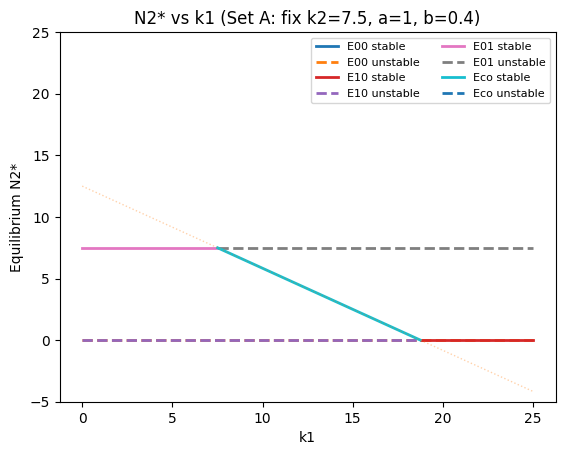

In [19]:
def branches_vs_k1(k1_values, k2, a, b, r1=1.0, r2=1.0):
    out = {"E00": [], "E10": [], "E01": [], "Eco": []}
    for k1 in k1_values:
        E = equilibria(k1, k2, a, b)
        labels = ["E00","E10","E01","Eco"]
        for lab, eq in zip(labels, E):
            n1, n2 = eq
            ev, st, feas = stability_at(eq, r1, r2, k1, k2, a, b)
            out[lab].append((n1, n2, st, feas))
    for lab in out:
        out[lab] = np.array(out[lab], dtype=object)
    return out

def plot_bifurcation_k1(title, k2, a, b, k1_min=0, k1_max=25, r1=1.0, r2=1.0):
    k1_values = np.linspace(k1_min, k1_max, 900)
    br = branches_vs_k1(k1_values, k2, a, b, r1=r1, r2=r2)

    plt.figure()
    for lab, arr in br.items():
        n2 = np.array([x[1] for x in arr], dtype=float)
        stable = np.array([x[2] for x in arr], dtype=bool)
        feas = np.array([x[3] for x in arr], dtype=bool)

        plt.plot(k1_values[feas & stable], n2[feas & stable], linewidth=2, label=f"{lab} stable")
        plt.plot(k1_values[feas & ~stable], n2[feas & ~stable], linewidth=2, linestyle="--", label=f"{lab} unstable")
        plt.plot(k1_values[~feas], n2[~feas], linewidth=1, linestyle=":", alpha=0.35)

    plt.xlabel("k1")
    plt.ylabel("Equilibrium N2*")
    plt.title(title)
    plt.ylim(-5, max(25, k2+5))
    plt.legend(ncol=2, fontsize=8)
    plt.show()

plot_bifurcation_k1("N2* vs k1 (Set A: fix k2=7.5, a=1, b=0.4)", k2=7.5, a=1.0, b=0.4, k1_min=0, k1_max=25)


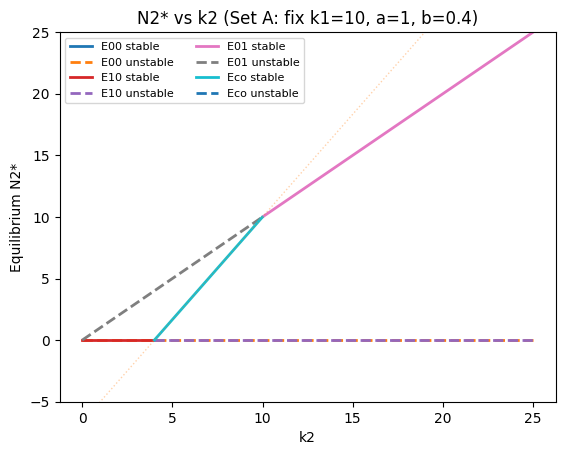

In [20]:
def branches_vs_k2(k2_values, k1, a, b, r1=1.0, r2=1.0):
    out = {"E00": [], "E10": [], "E01": [], "Eco": []}
    for k2 in k2_values:
        E = equilibria(k1, k2, a, b)
        labels = ["E00","E10","E01","Eco"]
        for lab, eq in zip(labels, E):
            n1, n2 = eq
            ev, st, feas = stability_at(eq, r1, r2, k1, k2, a, b)
            out[lab].append((n1, n2, st, feas))
    for lab in out:
        out[lab] = np.array(out[lab], dtype=object)
    return out

def plot_bifurcation_k2(title, k1, a, b, k2_min=0, k2_max=25, r1=1.0, r2=1.0):
    k2_values = np.linspace(k2_min, k2_max, 900)
    br = branches_vs_k2(k2_values, k1, a, b, r1=r1, r2=r2)

    plt.figure()
    for lab, arr in br.items():
        n2 = np.array([x[1] for x in arr], dtype=float)
        stable = np.array([x[2] for x in arr], dtype=bool)
        feas = np.array([x[3] for x in arr], dtype=bool)

        plt.plot(k2_values[feas & stable], n2[feas & stable], linewidth=2, label=f"{lab} stable")
        plt.plot(k2_values[feas & ~stable], n2[feas & ~stable], linewidth=2, linestyle="--", label=f"{lab} unstable")
        plt.plot(k2_values[~feas], n2[~feas], linewidth=1, linestyle=":", alpha=0.35)

    plt.xlabel("k2")
    plt.ylabel("Equilibrium N2*")
    plt.title(title)
    plt.ylim(-5, max(25, k1+5))
    plt.legend(ncol=2, fontsize=8)
    plt.show()

plot_bifurcation_k2("N2* vs k2 (Set A: fix k1=10, a=1, b=0.4)", k1=10.0, a=1.0, b=0.4, k2_min=0, k2_max=25)


## What the branches mean

When you see multiple equilibrium “lines” in a bifurcation plot:

- **E10:** $N_2^*=0$, $N_1^*=k_1$ (species 1 only)
- **E01:** $N_1^*=0$, $N_2^*=k_2$ (species 2 only)
- **Eco:** coexistence intersection (may be stable or unstable; may become infeasible)
- portions where $N_1^*<0$ or $N_2^*<0$ are **not biologically feasible** (these are the faint dotted parts)

```{note}
See also (theory notebook: [competitive-dynamics.ipynb](competitive-dynamics.ipynb)):
- Equilibria and local stability → Equilibria
- Equilibria and local stability → Jacobian and eigenvalues
```


---

# (2‑3) Mumby et al. coral–macroalgae model: phase portrait

The model of Mumby et al. (2007) describes the dynamics of corals and algae. The model in the practical is:

$$
\begin{aligned}
\dot C &= \gamma C T - aMC - dC,\\
\dot M &= rMT + aMC - gM,\\
T &= 1 - M - C.
\end{aligned}
$$

Investigate the dynamics in the phase plane as explained in the previous exercise.

Use parameters:
- $g=0.42$, $r=2$, $\gamma=1$, $a=0.5$, $d=0.8$

We reproduce phase‑plane plots analogous to (2‑1), but now variables are **fractions of space**.

```{note}
See also (phase‑plane technique, theory notebook: [competitive-dynamics.ipynb](competitive-dynamics.ipynb)):
- Lotka–Volterra Competition: geometry in the phase plane
```


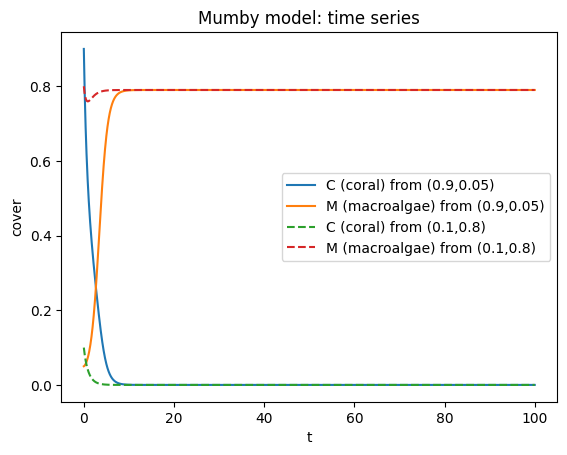

In [13]:
def mumby_rhs(t, y, g=0.42, r=2.0, gamma=1.0, a=0.5, d=0.8):
    C, M = y
    T = 1 - C - M
    dC = gamma*C*T - a*M*C - d*C
    dM = r*M*T + a*M*C - g*M
    return [dC, dM]

# simulate two initial conditions
t_span = (0, 100)
t_eval = np.linspace(0, 100, 2001)

sol1 = solve_ivp(mumby_rhs, t_span, [0.9, 0.05], t_eval=t_eval, rtol=1e-9, atol=1e-12)
sol2 = solve_ivp(mumby_rhs, t_span, [0.1, 0.8], t_eval=t_eval, rtol=1e-9, atol=1e-12)

C1, M1 = sol1.y
C2, M2 = sol2.y

plt.figure()
plt.plot(sol1.t, C1, label="C (coral) from (0.9,0.05)")
plt.plot(sol1.t, M1, label="M (macroalgae) from (0.9,0.05)")
plt.plot(sol2.t, C2, "--", label="C (coral) from (0.1,0.8)")
plt.plot(sol2.t, M2, "--", label="M (macroalgae) from (0.1,0.8)")
plt.xlabel("t"); plt.ylabel("cover")
plt.title("Mumby model: time series")
plt.legend()
plt.show()


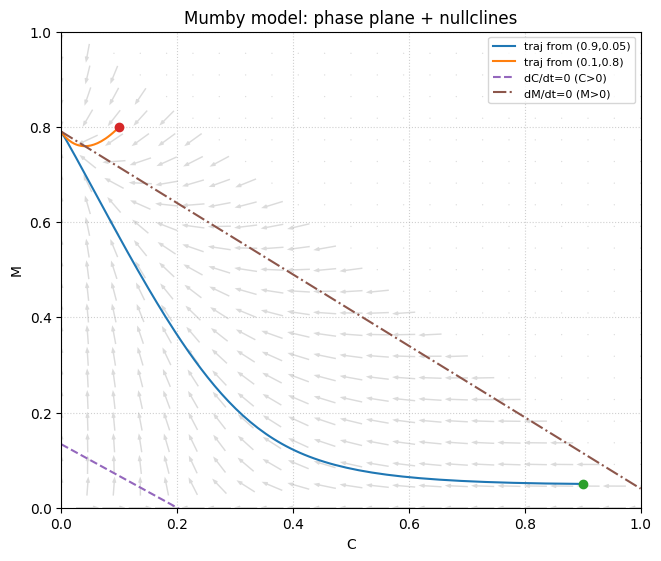

In [14]:
# Phase plane + nullclines

# We'll plot trajectories and add the analytical nullclines derived from dividing by C or M:

# dC/dt=0 for C>0: gamma(1-C-M) - aM - d = 0

# dM/dt=0 for M>0: r(1-C-M) + aC - g = 0



g=0.42; r=2.0; gamma=1.0; a_m=0.5; d=0.8



C_grid = np.linspace(0, 1, 600)



# From gamma(1-C-M) - aM - d = 0 -> gamma(1-C-M) = d + aM

# -> gamma - gamma*C - gamma*M = d + aM -> (gamma + a)M = gamma - d - gamma*C

M_nullC = (gamma - d - gamma*C_grid)/(gamma + a_m)



# From r(1-C-M)+aC-g=0 -> r - rC - rM + aC - g = 0 -> rM = r - g + (a-r)C

M_nullM = (r - g + (a_m - r)*C_grid)/r



fig, ax = plt.subplots(figsize=(6.5, 5.5), constrained_layout=True)



# Add vector field in the feasible simplex C>=0, M>=0, C+M<=1

add_vector_field(

    ax,

    mumby_rhs,

    (0, 1),

    (0, 1),

    args=(g, r, gamma, a_m, d),

    density=23,

    mask_fn=lambda C, M: (C + M) <= 1.0,

)



ax.plot(C1, M1, label="traj from (0.9,0.05)")

ax.plot(C2, M2, label="traj from (0.1,0.8)")

ax.plot([0.9],[0.05], marker="o", linestyle="none")

ax.plot([0.1],[0.8], marker="o", linestyle="none")

ax.plot(C_grid, M_nullC, "--", label="dC/dt=0 (C>0)")

ax.plot(C_grid, M_nullM, "-.", label="dM/dt=0 (M>0)")



ax.set_xlim(0, 1)

ax.set_ylim(0, 1)

ax.set_xlabel("C")

ax.set_ylabel("M")

ax.set_title("Mumby model: phase plane + nullclines")

ax.grid(True, linestyle=':', alpha=0.6)

ax.legend(fontsize=8)

plt.show()


---

# (2‑3 cont.) An analysis of the codim‑2 cusp bifurcation (minimal hysteresis model)

In Scheffer et al. (2001) a minimal model for an ecosystem with hysteresis is given. The variable $x$ is a property (for instance a nutrient) of the ecosystem, and changes over time as

$$
\frac{dx}{dt} = a - bx + r f(x).
$$

The parameter $a$ represents an environmental factor that promotes $x$, $b$ is the rate at which $x$ decays in the system, and $r f(x)$ is a positive feedback term whose strength is controlled by $r$. The function $f$ is given by the Hill function

$$
f(x) = \frac{x^p}{x^p+h^p}.
$$

Make a bifurcation diagram as in the previous exercise. As initial parameters use $r=0$, $h=4$, $p=3$, $a=1$, $b=1$.

- Choose an appropriate starting value for $x$ (try $x(0)=0$) and make the bifurcation diagram by increasing $r$ from $0$ to $20$. Save and plot.
- Then do it again, now starting at $r=20$ (and try $x(0)=20$) and decrease the value of $r$ from $20$ to $0$.

What do you see? What happens in the middle? Is the bifurcation diagram complete? Can you find the missing branch?

```{note}
See also (theory notebook: [competitive-dynamics.ipynb](competitive-dynamics.ipynb)):
- A minimal hysteresis model (positive feedback)
- Notes on the “missing branch”
```


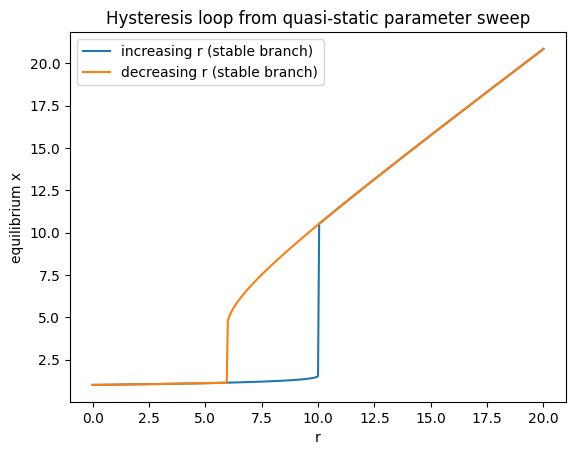

In [12]:
def hill(x, h=4.0, p=3.0):
    return x**p/(x**p + h**p)

def hyster_rhs(t, x, a=1.0, b=1.0, r=0.0, h=4.0, p=3.0):
    return a - b*x + r*hill(x, h=h, p=p)

def relax_equilibrium(r, x0, a=1.0, b=1.0, h=4.0, p=3.0):
    sol = solve_ivp(lambda t, x: hyster_rhs(t, x, a=a, b=b, r=r, h=h, p=p),
                    (0, 200), [x0], t_eval=np.linspace(0,200,2000),
                    rtol=1e-9, atol=1e-12)
    return sol.y[0, -1]

a0=1; b0=1; h0=4; p0=3
rs_up = np.linspace(0, 20, 401)
rs_dn = np.linspace(20, 0, 401)

x_up=[]
x=0.0
for r in rs_up:
    x = relax_equilibrium(r, x, a=a0,b=b0,h=h0,p=p0)
    x_up.append(x)

x_dn=[]
x = x_up[-1]
for r in rs_dn:
    x = relax_equilibrium(r, x, a=a0,b=b0,h=h0,p=p0)
    x_dn.append(x)

plt.figure()
plt.plot(rs_up, x_up, label="increasing r (stable branch)")
plt.plot(rs_dn, x_dn, label="decreasing r (stable branch)")
plt.xlabel("r"); plt.ylabel("equilibrium x")
plt.title("Hysteresis loop from quasi‑static parameter sweep")
plt.legend()
plt.show()
